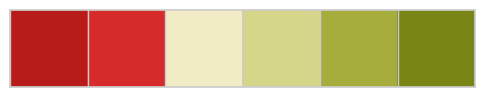

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter

from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Clustering Algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from itertools import product
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# scipy library for hierarchical clustering
from scipy.cluster.hierarchy import ward, dendrogram, linkage
from scipy.cluster import hierarchy
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors
   
colors = ["#B71C1B","#D72A2B","#F2ECC6","#D5D68A","#A6AD3C","#798517"]
colors1 = ["#B71C1B","#D72A2B","#D5D68A","#A6AD3C","#798517"]
colors2 = ["#F2ECC6","#D5D68A","#A6AD3C","#798517","#D72A2B"]
cmap = matplotlib.colors.ListedColormap(colors2)

sns.palplot(sns.color_palette(colors))

In [2]:
Data = pd.read_csv('Customer_Data.csv')

In [3]:
df = pd.DataFrame(Data)
df.head(5)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [4]:
# View dimensions of dataset   
rows, col = df.shape
print ("Dimensions of dataset: {}" . format (df.shape))
print ('Rows:', rows, '\nColumns:', col)

Dimensions of dataset: (8950, 18)
Rows: 8950 
Columns: 18


In [5]:
# Information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

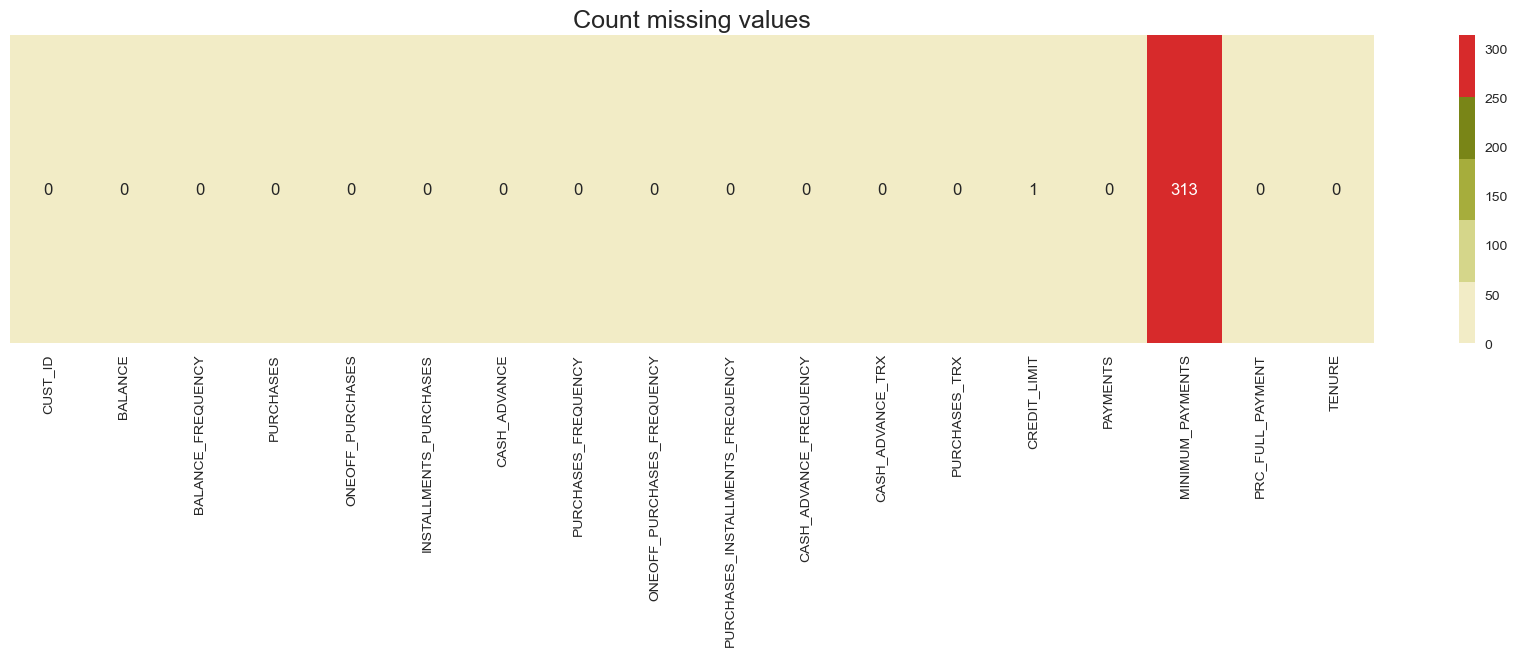

In [6]:
# Missing values
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap=cmap, annot=True,
             fmt='0.0f').set_title('Count missing values', fontsize=18)
plt.show()

In [7]:
# Drop the missing value for 'Credit Limit'
df = df.drop(5203)

# Reset index 
df = df.reset_index(drop=True)

# Dimensions of dataset 
print(df.shape)

(8949, 18)


In [8]:
# Fill missing values in the 'MINIMUM_PAYMENTS' column with the median value
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

# Print the shape of the DataFrame
print(df.shape)

(8949, 18)


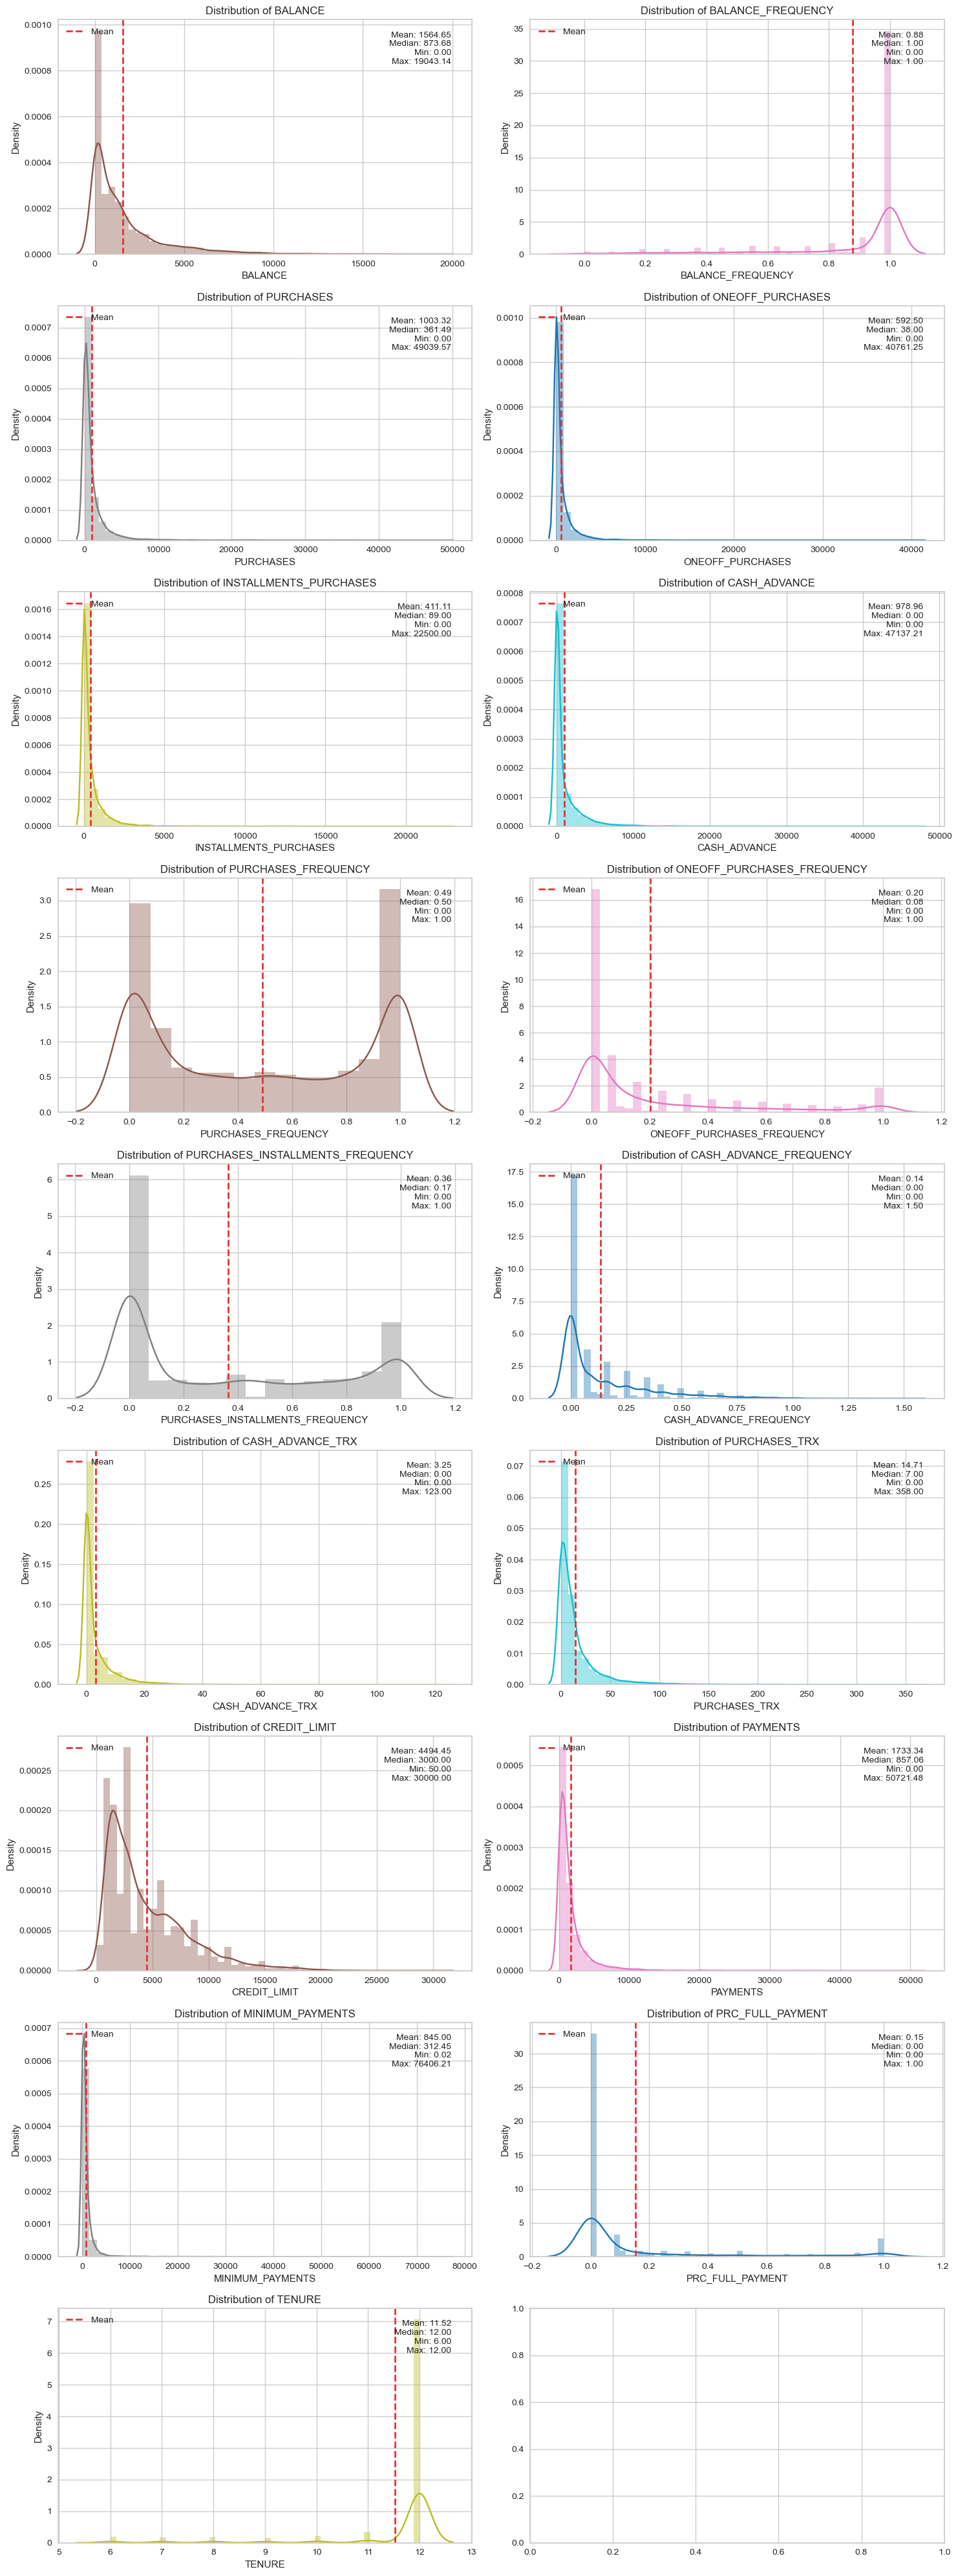

In [9]:
# Check variables distribution
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(15, 40))

# Define colors to use for each feature
colors = ['#8C564B', '#E377C2', '#7F7F7F', '#1F77B4', '#BCBD22', '#17BECF']

# Loop through each column and plot distribution
# Exclude 'CUST_ID' column from the loop as it contains string values
for i, column in enumerate(df.select_dtypes(include=np.number).columns): 
    # Plot histogram with density curve
    sns.distplot(df[column], color=colors[i%len(colors)], ax=axes[i//2, i%2])
    
    # Add vertical lines for mean
    axes[i//2, i%2].axvline(x=df[column].mean(), color='#e33434', linestyle='--', linewidth=2, label='Mean')
    
    # Add text box with important statistics
    median = df[column].median()
    axes[i//2, i%2].text(0.95, 0.95, 
                          'Mean: {:.2f}\nMedian: {:.2f}\nMin: {:.2f}\nMax: {:.2f}'.format(
                              df[column].mean(), median, df[column].min(), df[column].max()),
                          transform=axes[i//2, i%2].transAxes,
                          fontsize=10, va='top', ha='right')
    
    # Add legend
    axes[i//2, i%2].legend(loc="upper left")
    
    # Set title of subplot
    axes[i//2, i%2].set_title('Distribution of '+ column)
    
# Add overall title and adjust spacing
fig.tight_layout()

In [10]:
# Assign the column names of the original DataFrame to the cols variable
# Exclude the 'CUST_ID' column as it is not a numerical feature
cols = df.drop(columns=['CUST_ID']).columns  

# Scale the features using StandardScaler
scaler = StandardScaler()

# Fit the scaler to data and transform it, excluding the 'CUST_ID' column
scaled_col = scaler.fit_transform(df[cols]) # Pass only numerical columns to fit_transform

# Create a DataFrame from the scaled features
scaled_col = pd.DataFrame(scaled_col, columns=cols) # Use the correct column names

scaled_col.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.732054          -0.249881  -0.424934         -0.356957   
1  0.786858           0.134049  -0.469584         -0.356957   
2  0.447041           0.517980  -0.107716          0.108843   
3  0.049015          -1.017743   0.231995          0.546123   
4 -0.358849           0.517980  -0.462095         -0.347317   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349114     -0.466805            -0.806649   
1               -0.454607      2.605438            -1.221928   
2               -0.454607     -0.466805             1.269742   
3               -0.454607     -0.368678            -1.014290   
4               -0.454607     -0.466805            -1.014290   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678716                         -0.707409   
1                   -0.678716                         -0.917090   
2                    2.673295                         -0.917090   
3                   -0.399383                         -0.917090   
4                   -0.399383                         -0.917090   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675294         -0.476083      -0.511381     -0.960380   
1                0.573949          0.110032      -0.591841      0.688601   
2               -0.675294         -0.476083      -0.109082      0.826016   
3               -0.258882         -0.329554      -0.551611      0.826016   
4               -0.675294         -0.476083      -0.551611     -0.905414   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0 -0.529026         -0.302427         -0.525588  0.360541  
1  0.818546          0.097453          0.234159  0.360541  
2 -0.383857         -0.093330         -0.525588  0.360541  
3 -0.598733         -0.228291         -0.525588  0.360541  
4 -0.364421         -0.257295         -0.525588  0.360541

In [11]:
# Set the parameters for the KMeans algorithm
kmeans_params = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 1,
                 "tol": 1e-4, "algorithm": "elkan", "verbose": 0}

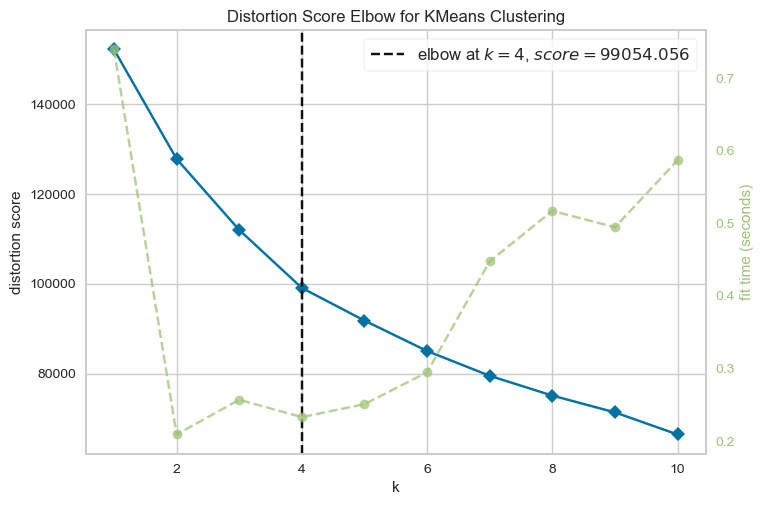

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# Initialize KMeans model with the given parameters
k = (1, 11)
kmeans_model = KMeans(n_clusters=k, **kmeans_params)

# Create elbow plot visualizer with range of k values and timings enabled
elbow_visualizer = KElbowVisualizer(kmeans_model, k=k, timings=True)

# Fit the data to the visualizer
elbow_visualizer.fit(scaled_col)

# Add a title to the elbow plot
elbow_visualizer.ax.set_title('Elbow Plot for KMeans Clustering')

# Finalize and render the figure
elbow_visualizer.show()

In [13]:
# Calculate silhouette coefficient and calinski harabasz coefficient
silhouette_coef = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(scaled_col)
    score = silhouette_score(scaled_col, kmeans.labels_)
    silhouette_coef.append(score)

calinski_harabasz_coef = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(scaled_col)
    score = calinski_harabasz_score(scaled_col, kmeans.labels_)
    calinski_harabasz_coef.append(score)

In [14]:
# Create a dataframe to store the scores
scores_kmeans = pd.DataFrame({'k': range(2,11),
'Silhouette Score': silhouette_coef,
'Calinski-Harabasz Score': calinski_harabasz_coef})

# Find the best k for each score
best_k_silhouette = scores_kmeans.loc[scores_kmeans['Silhouette Score'].idxmax(), 'k']
best_k_calinski_harabaz = scores_kmeans.loc[scores_kmeans['Calinski-Harabasz Score'].idxmax(), 'k']

In [15]:
print("\nScores for Different Numbers of Clusters:")
scores_kmeans.style.background_gradient(cmap=cmap).set_properties(**{'font-family': 'Segoe UI'}).hide(axis="index") 


Scores for Different Numbers of Clusters:


In [16]:
def plot_evaluation(sh_score, ch_score, name, x=range(2,11)):
    """
    for draw evaluation plot include silhouette_score and calinski_harabasz_score.
        sh_score(list): include silhouette_score of models
        ch_score(list): include calinski_harabasz_score of models
        name(string): name of clustering algorithm
        x(list): has range of number for x axis
    """
    colors = ["#B71C1B","#D72A2B","#F2ECC6","#D5D68A","#A6AD3C","#798517"]
    fig, ax = plt.subplots(1,2, figsize=(15,7), dpi=100)
    ax[0].plot(x, sh_score, color=colors[1], marker='o', ms=7, mfc=colors[-1])
    ax[1].plot(x, ch_score, color=colors[1], marker='o', ms=7, mfc=colors[-1])
    ax[0].set_xlabel("Number of Clusters", labelpad=20)
    ax[0].set_ylabel("Silhouette Coefficient", labelpad=20)
    ax[1].set_xlabel("Number of Clusters", labelpad=20)
    ax[1].set_ylabel("calinski Harabasz Coefficient", labelpad=20)
    plt.suptitle(f'Evaluate {name} Clustering', y=0.9)
    plt.tight_layout(pad=3)
    plt.show()

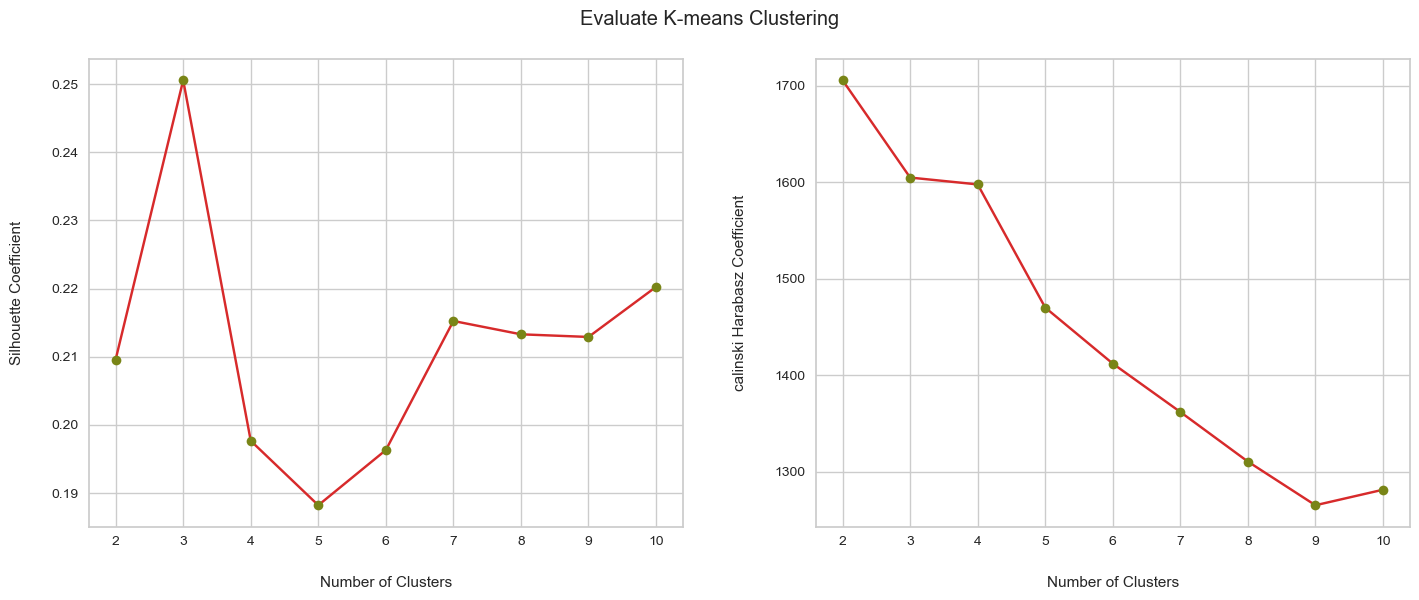

In [17]:
# Visualize plots of silhouette and calinski harabasz scores for kmeans models
plot_evaluation(silhouette_coef, calinski_harabasz_coef, 'K-means')

In [18]:
#Optimal number of clusters based on the Elbow method and silhouette analysis
optimal_k = 4 # Example: Choose 4 based on visualization, replace with your chosen value

# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, **kmeans_params)
kmeans.fit(scaled_col)

# Add cluster labels to the original DataFrame
df['cluster'] = kmeans.labels_

# Analyze the customer segments
segment_analysis = df.groupby('cluster').agg({
    'BALANCE': 'mean',
    'PURCHASES': 'mean',
    'ONEOFF_PURCHASES': 'mean',
    'INSTALLMENTS_PURCHASES': 'mean',
    'CASH_ADVANCE': 'mean',
    'CREDIT_LIMIT': 'mean',
    'PAYMENTS': 'mean',
    'MINIMUM_PAYMENTS': 'mean',
    'PRC_FULL_PAYMENT': 'mean'
})

print(segment_analysis)

             BALANCE    PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
cluster                                                                       
0        1012.995969   270.281184        210.068828               60.479311   
1         894.768927  1236.263333        593.995933              642.541696   
2        4602.449658   501.862982        320.188797              181.759123   
3        3551.153761  7681.620098       5095.878826             2587.208264   

         CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
cluster                                                              
0          597.154288   3278.263348   975.328059        554.010557   
1          209.816318   4214.013741  1331.325429        639.742512   
2         4521.509581   7546.160857  3484.054216       2003.675546   
3          653.638891   9696.943765  7288.739497       1972.768082   

         PRC_FULL_PAYMENT  
cluster                    
0                0.078002  
1                0.2

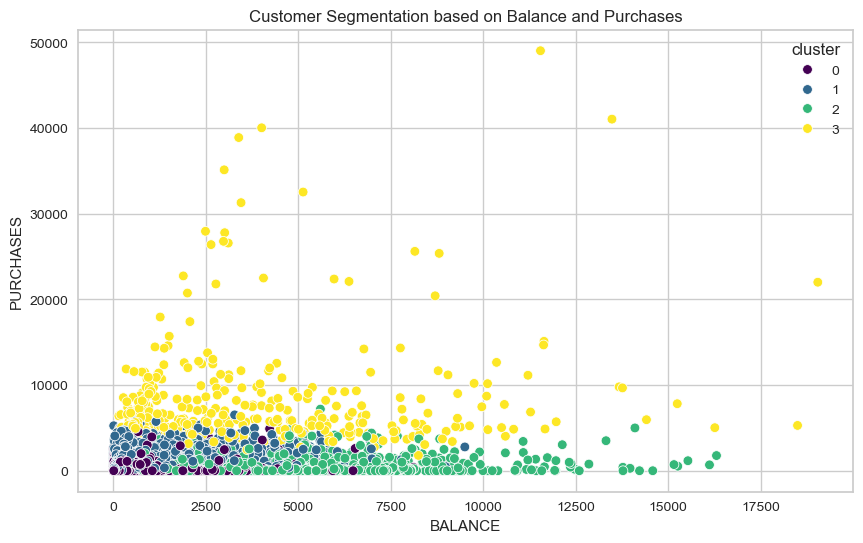

In [19]:
# Visualization of segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='BALANCE', y='PURCHASES', hue='cluster', data=df, palette='viridis')
plt.title('Customer Segmentation based on Balance and Purchases')
plt.show()

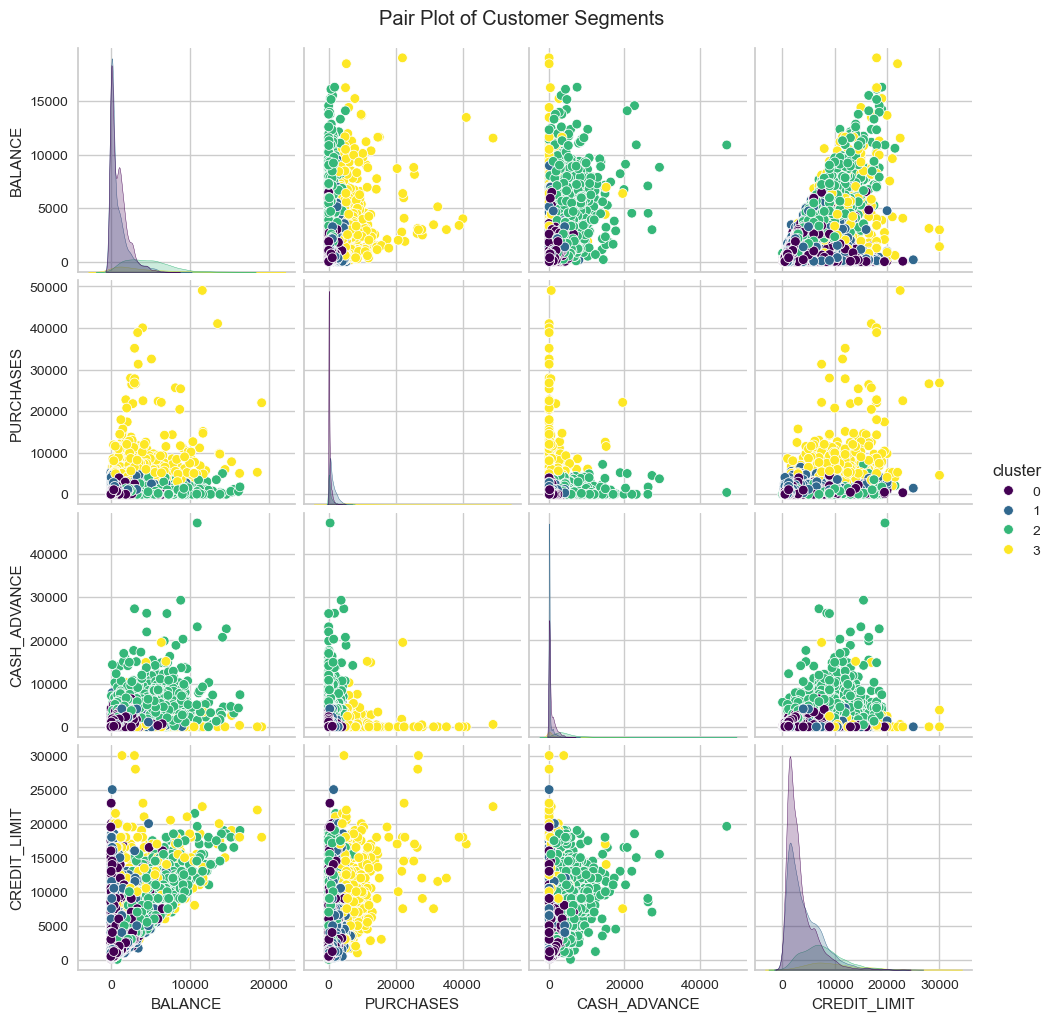

In [20]:
# Visualization of segments with more features
import plotly.express as px

features_to_plot = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

#3D scatter plot
fig = px.scatter_3d(df, 
                    x=features_to_plot[0], 
                    y=features_to_plot[1], 
                    z=features_to_plot[2],
                    color='cluster',  # Color points by cluster
                    opacity=0.7,
                    hover_data=['CUST_ID'] + features_to_plot, # Show customer ID and features on hover
                    title='Customer Segmentation (3D View)')


fig.show()
# Create a pair plot for multiple features
sns.pairplot(df, hue='cluster', vars=features_to_plot[:4], palette='viridis') # Limit to 4 features for pairplot
plt.suptitle('Pair Plot of Customer Segments', y=1.02)
plt.show()


In [21]:
# Create more detailed segment analysis (customize as needed)
segment_stats = df.groupby('cluster').agg({
    'BALANCE': ['mean', 
                'median', 'std'],
    'PURCHASES': ['mean', 'median', 'std'],
    'CASH_ADVANCE': ['mean', 'median', 'std'],
    'CREDIT_LIMIT': ['mean', 'median', 'std'],
    'PAYMENTS': ['mean', 'median', 'std'],
    'PRC_FULL_PAYMENT': ['mean', 'median', 'std']
})

segment_stats

BALANCE                              PURCHASES           \
                mean       median          std         mean   median   
cluster                                                                
0        1012.995969   765.109593  1098.620530   270.281184    79.24   
1         894.768927   337.224040  1212.287857  1236.263333   892.15   
2        4602.449658  4274.488095  2755.726795   501.862982    85.54   
3        3551.153761  2492.726282  3344.579386  7681.620098  5848.55   

                     CASH_ADVANCE                           CREDIT_LIMIT  \
                 std         mean       median          std         mean   
cluster                                                                    
0         467.696428   597.154288   117.579435   920.559229  3278.263348   
1        1041.292840   209.816318     0.000000   600.834189  4214.013741   
2         863.298717  4521.509581  3666.845105  3623.855459  7546.160857   
3        5978.185287   653.638891     0.000000  1872.977038  9696.943765   

                                 PAYMENTS                            \
         median          std         mean       median          std   
cluster                                                               
0        2500.0  2655.946216   975.328059   534.740352  1579.214154   
1        3000.0  3261.419043  1331.325429   938.582557  1275.006093   
2        7000.0  3745.650220  3484.054216  1963.299182  4210.835245   
3        9000.0  4824.345602  7288.739497  5446.940305  6875.811470   

        PRC_FULL_PAYMENT                      
                    mean    median       std  
cluster                                       
0               0.078002  0.000000  0.205764  
1               0.269313  0.083333  0.357420  
2               0.034888  0.000000  0.103250  
3               0.286707  0.000000  0.392138